# Notebook to create the MIRI MRS dither patterns #

In [1]:
import os as os
import numpy as np
from numpy.testing import utils
from numpy.testing import assert_allclose
import pdb as pdb

import matplotlib as mpl
import matplotlib.pyplot as plt

data_dir=os.path.expandvars('$MIRICOORD_DATA_DIR')
import miricoord.miricoord.mrs.mrs_tools as mrst
import miricoord.miricoord.mrs.makedither.makedither_mrs as mrsd
import miricoord.miricoord.mrs.makesiaf.makesiaf_mrs as makesiaf

### Output Files ###
Output will be written to $MIRICOORD_DATA_DIR/dithers/temp/

### Use CDP-8b distortion solution ###

In [2]:
mrst.set_toolversion('cdp8b')
mrst.version()

'cdp8b'

In [3]:
# Define the field boundaries used by the SIAF
values1A=makesiaf.create_siaf_oneband('1A')
values1B=makesiaf.create_siaf_oneband('1B')
values1C=makesiaf.create_siaf_oneband('1C')

values2A=makesiaf.create_siaf_oneband('2A')
values2B=makesiaf.create_siaf_oneband('2B')
values2C=makesiaf.create_siaf_oneband('2C')

values3A=makesiaf.create_siaf_oneband('3A')
values3B=makesiaf.create_siaf_oneband('3B')
values3C=makesiaf.create_siaf_oneband('3C')

values4A=makesiaf.create_siaf_oneband('4A')
values4B=makesiaf.create_siaf_oneband('4B')
values4C=makesiaf.create_siaf_oneband('4C')

### Calculate actual pixel sizes and slice widths ###

In [4]:
mrsd.setsizes(verbose=1)

Slice widths:  [0.17721014 0.27971819 0.38981378 0.65603803]
Pixel sizes:  [0.1905436  0.1947341  0.2520443  0.26955285]


### Make dithers in the old way ###

In [5]:
v2_cdp6_ch1,v3_cdp6_ch1=mrsd.makepattern_cdp6_ch1()
v2_cdp6_ch2,v3_cdp6_ch2=mrsd.makepattern_cdp6_ch2()
v2_cdp6_ch3,v3_cdp6_ch3=mrsd.makepattern_cdp6_ch3()
v2_cdp6_ch4,v3_cdp6_ch4=mrsd.makepattern_cdp6_ch4()

### Ch1 point-source dithers ###

In [6]:
v2_ch1,v3_ch1=mrsd.makepattern_ch1()

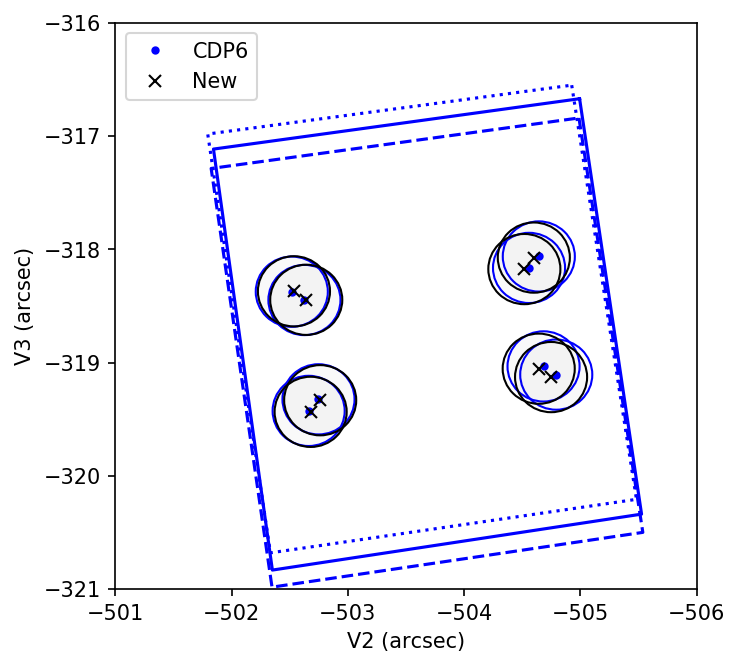

In [7]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()
plt.xlim(-501,-506)
plt.ylim(-321,-316)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')
    
plt.plot(v2_cdp6_ch1,v3_cdp6_ch1,'.',color='b',label='CDP6')
for i in range(0,v2_ch1.size):
    circle1 = mpl.patches.Circle((v2_cdp6_ch1[i], v3_cdp6_ch1[i]), mrsd.maxfwhm(1),linewidth=1,edgecolor='b', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(v2_ch1,v3_ch1,'x',color='black',label='New')
for i in range(0,v2_ch1.size):
    circle1 = mpl.patches.Circle((v2_ch1[i], v3_ch1[i]), mrsd.maxfwhm(1),linewidth=1,edgecolor='black', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(values1A['inscr_v2_corners'],values1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(values1B['inscr_v2_corners'],values1B['inscr_v3_corners'],'--',color='b',linewidth=1.5)
plt.plot(values1C['inscr_v2_corners'],values1C['inscr_v3_corners'],':',color='b',linewidth=1.5)
plt.legend()

### Ch2 point-source dithers ###

In [8]:
v2_ch2,v3_ch2=mrsd.makepattern_ch2()

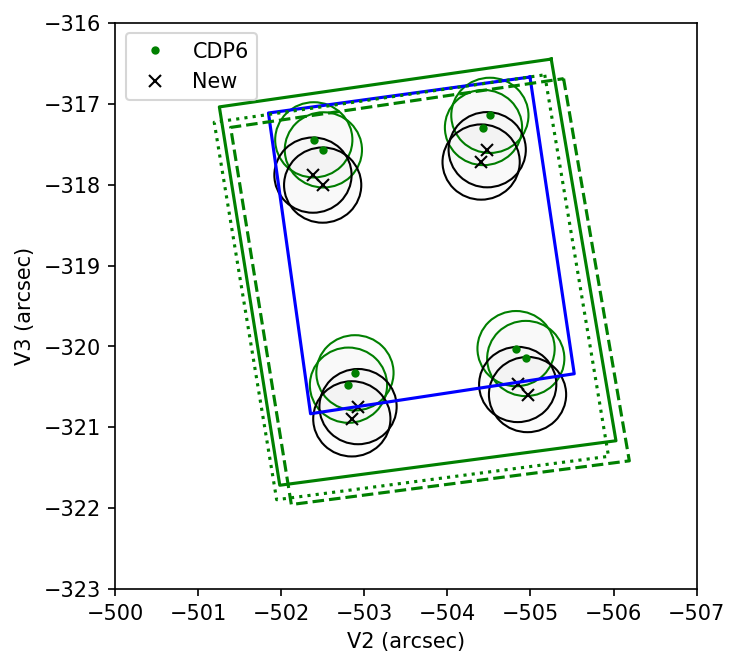

In [ ]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-500,-507)
plt.ylim(-323,-316)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_cdp6_ch2,v3_cdp6_ch2,'.',color='g',label='CDP6')
for i in range(0,v2_ch2.size):
    circle1 = mpl.patches.Circle((v2_cdp6_ch2[i], v3_cdp6_ch2[i]), mrsd.maxfwhm(2),linewidth=1,edgecolor='g', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(v2_ch2,v3_ch2,'x',color='black',label='New')
for i in range(0,v2_ch2.size):
    circle1 = mpl.patches.Circle((v2_ch2[i], v3_ch2[i]), mrsd.maxfwhm(2),linewidth=1,edgecolor='black', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)  
    
plt.plot(values1A['inscr_v2_corners'],values1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(values2A['inscr_v2_corners'],values2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(values2B['inscr_v2_corners'],values2B['inscr_v3_corners'],'--',color='g',linewidth=1.5)
plt.plot(values2C['inscr_v2_corners'],values2C['inscr_v3_corners'],':',color='g',linewidth=1.5)
plt.legend()

### Ch3 point-source dithers ###

In [ ]:
v2_ch3,v3_ch3=mrsd.makepattern_ch3()

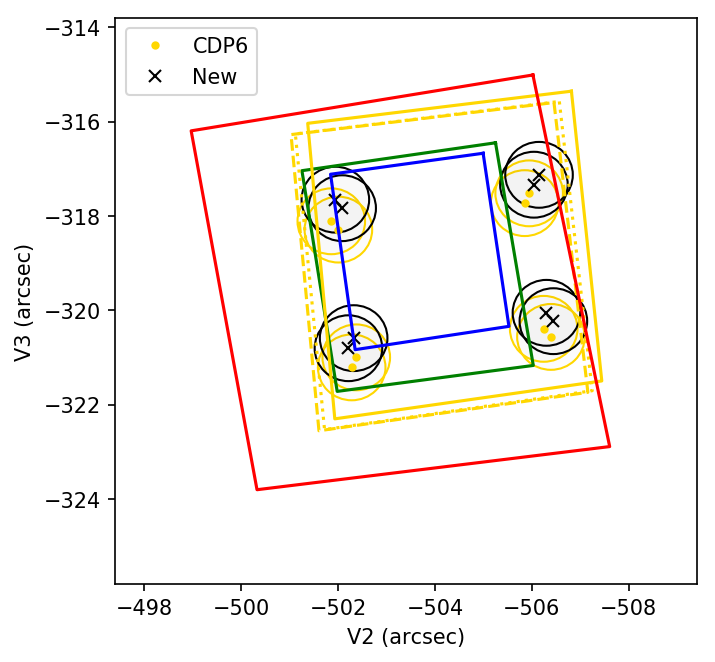

In [ ]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_cdp6_ch3,v3_cdp6_ch3,'.',color='gold',label='CDP6')
for i in range(0,v2_ch3.size):
    circle1 = mpl.patches.Circle((v2_cdp6_ch3[i], v3_cdp6_ch3[i]), mrsd.maxfwhm(3),linewidth=1,edgecolor='gold', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(v2_ch3,v3_ch3,'x',color='black',label='New')
for i in range(0,v2_ch3.size):
    circle1 = mpl.patches.Circle((v2_ch3[i], v3_ch3[i]), mrsd.maxfwhm(3),linewidth=1,edgecolor='black', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)  
    
plt.plot(values1A['inscr_v2_corners'],values1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(values2A['inscr_v2_corners'],values2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(values3A['inscr_v2_corners'],values3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(values3B['inscr_v2_corners'],values3B['inscr_v3_corners'],'--',color='gold',linewidth=1.5)
plt.plot(values3C['inscr_v2_corners'],values3C['inscr_v3_corners'],':',color='gold',linewidth=1.5)
plt.plot(values4A['inscr_v2_corners'],values4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.legend()

### Ch4 point-source dithers ###

In [ ]:
v2_ch4,v3_ch4=mrsd.makepattern_ch4()

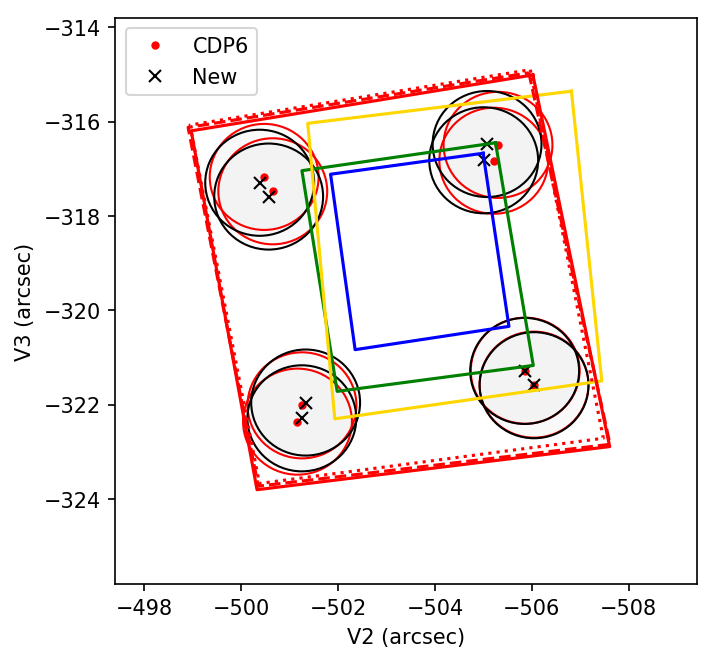

In [ ]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_cdp6_ch4,v3_cdp6_ch4,'.',color='r',label='CDP6')
for i in range(0,v2_ch4.size):
    circle1 = mpl.patches.Circle((v2_cdp6_ch4[i], v3_cdp6_ch4[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='r', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(v2_ch4,v3_ch4,'x',color='black',label='New')
for i in range(0,v2_ch4.size):
    circle1 = mpl.patches.Circle((v2_ch4[i], v3_ch4[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='black', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(values1A['inscr_v2_corners'],values1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(values2A['inscr_v2_corners'],values2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(values3A['inscr_v2_corners'],values3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(values4A['inscr_v2_corners'],values4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.plot(values4B['inscr_v2_corners'],values4B['inscr_v3_corners'],'--',color='r',linewidth=1.5)
plt.plot(values4C['inscr_v2_corners'],values4C['inscr_v3_corners'],':',color='r',linewidth=1.5)
plt.legend()

### Make the extended source patterns ###

In [ ]:
v2_ext_all,v3_ext_all=mrsd.makepattern_ext_all()
v2_ext_ch1,v3_ext_ch1=mrsd.makepattern_ext_ChX(v2_ch1,v3_ch1,1)
v2_ext_ch2,v3_ext_ch2=mrsd.makepattern_ext_ChX(v2_ch2,v3_ch2,2)
v2_ext_ch3,v3_ext_ch3=mrsd.makepattern_ext_ChX(v2_ch3,v3_ch3,3)
v2_ext_ch4,v3_ext_ch4=mrsd.makepattern_ext_ChX(v2_ch4,v3_ch4,4)

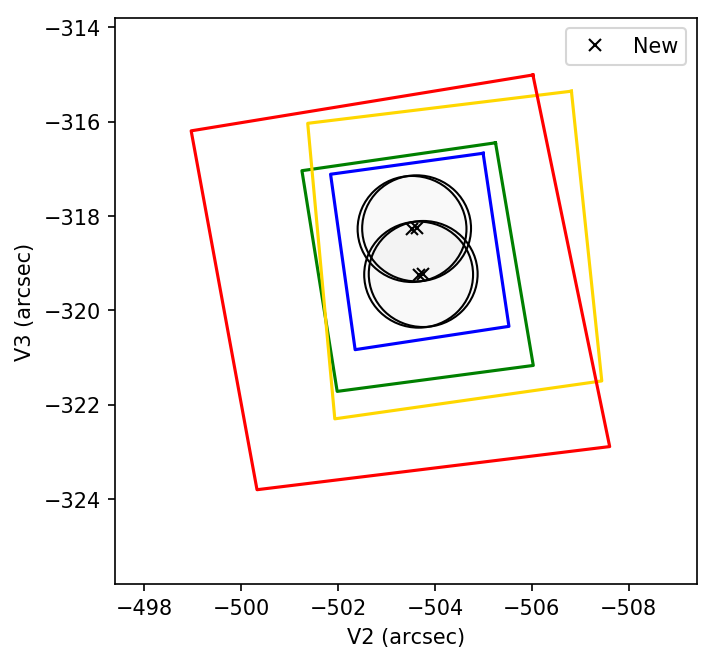

In [ ]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_ext_all,v3_ext_all,'x',color='black',label='New')
for i in range(0,v2_ext_all.size):
    circle1 = mpl.patches.Circle((v2_ext_all[i], v3_ext_all[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='black', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(values1A['inscr_v2_corners'],values1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(values2A['inscr_v2_corners'],values2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(values3A['inscr_v2_corners'],values3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(values4A['inscr_v2_corners'],values4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.legend()

### Put all of the patterns together and compute Ideal frame offsets ###

In [ ]:
# So far each of these gave specific v2/v3 pointing locations.
# Now they need to be converted to xidl, yidl offsets relative to the pointing origin for a given dither pattern
# (i.e., where the undithered pointing is for a given channel)

In [ ]:
# Positions index
index=np.arange(52)+1

# Ch1 point source pattern
v2_all,v3_all=v2_ch1,v3_ch1
ch_all=(np.ones(len(v2_ch1))).astype(int)
dx,dy=mrsd.compute_dxdyideal(v2_ch1,v3_ch1,1)
dx_all,dy_all=dx,dy
# Ch2 point source pattern
v2_all,v3_all=np.append(v2_all,v2_ch2),np.append(v3_all,v3_ch2)
ch_all=np.append(ch_all,(np.ones(len(v2_ch2))*2).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ch2,v3_ch2,2)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Ch3 point source pattern
v2_all,v3_all=np.append(v2_all,v2_ch3),np.append(v3_all,v3_ch3)
ch_all=np.append(ch_all,(np.ones(len(v2_ch3))*3).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ch3,v3_ch3,3)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Ch4 point source pattern
v2_all,v3_all=np.append(v2_all,v2_ch4),np.append(v3_all,v3_ch4)
ch_all=np.append(ch_all,(np.ones(len(v2_ch4))*4).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ch4,v3_ch4,4)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)

# Extended source ALL pattern
v2_all,v3_all=np.append(v2_all,v2_ext_all),np.append(v3_all,v3_ext_all)
ch_all=np.append(ch_all,(np.ones(len(v2_ext_all))).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ext_all,v3_ext_all,1)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Extended source Ch1 pattern
v2_all,v3_all=np.append(v2_all,v2_ext_ch1),np.append(v3_all,v3_ext_ch1)
ch_all=np.append(ch_all,(np.ones(len(v2_ext_ch1))).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ext_ch1,v3_ext_ch1,1)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Extended source Ch2 pattern
v2_all,v3_all=np.append(v2_all,v2_ext_ch2),np.append(v3_all,v3_ext_ch2)
ch_all=np.append(ch_all,(np.ones(len(v2_ext_ch2))*2).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ext_ch2,v3_ext_ch2,2)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Extended source Ch3 pattern
v2_all,v3_all=np.append(v2_all,v2_ext_ch3),np.append(v3_all,v3_ext_ch3)
ch_all=np.append(ch_all,(np.ones(len(v2_ext_ch3))*3).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ext_ch3,v3_ext_ch3,3)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Extended source Ch4 pattern
v2_all,v3_all=np.append(v2_all,v2_ext_ch4),np.append(v3_all,v3_ext_ch4)
ch_all=np.append(ch_all,(np.ones(len(v2_ext_ch4))*4).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ext_ch4,v3_ext_ch4,4)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)

### Write results to disk ###

In [ ]:
mrsd.writeresults_apt(index,dx_all,dy_all)
mrsd.writeresults_full(index,ch_all,v2_all,v3_all,dx_all,dy_all)

### Generate QA plots to disk ###

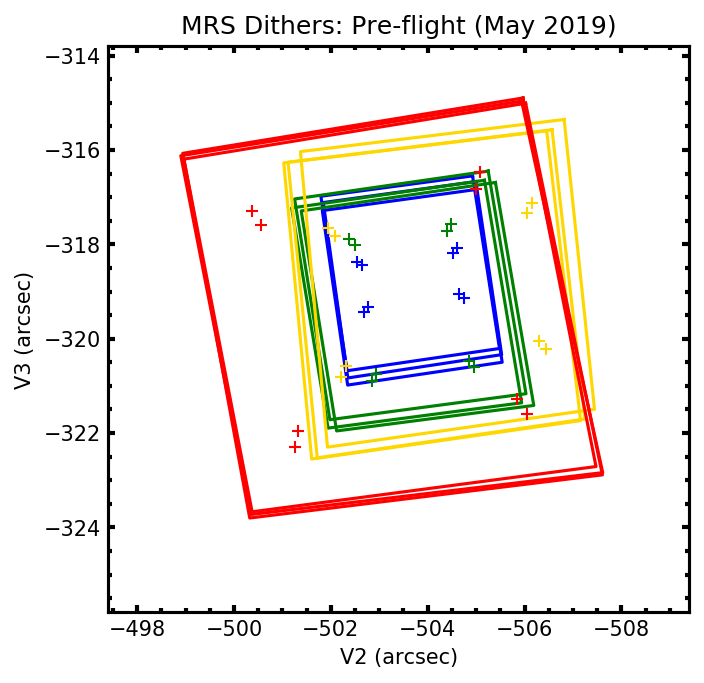

In [ ]:
mrsd.qaplot_ptsourceloc(v2_all,v3_all)

In [ ]:
mrsd.qaplot_extsourceloc(v2_all,v3_all)

In [ ]:
mrsd.qaplot_ps4all(v2_all,v3_all,dx_all,dy_all)

In [ ]:
mrsd.qaplot_ps2ch4(v2_all,v3_all,dx_all,dy_all)

In [ ]:
mrsd.qaplot_ext2all(v2_all,v3_all,dx_all,dy_all)

In [ ]:
mrsd.qaplot_ext2ch3(v2_all,v3_all,dx_all,dy_all)